In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import struct

# Чтение файлов

In [2]:
def read_xrd_dat(filepath, skip=8, datasize=4):
    with open(filepath, "rb") as file:
        file.seek((skip-1)*datasize)
        bin_data = file.read()
    n_elem = len(bin_data)//datasize
    return np.array(struct.unpack(f'{n_elem}I', bin_data))

In [3]:
xrd_data = {28: read_xrd_dat('28.DAT'),
            89: read_xrd_dat('89.DAT')}
angles = np.arange(1.5, 1.5+0.025*xrd_data[28].shape[0], 0.025)

# Визуализация
К тому же сразу найдем локальные максимумы

In [4]:
peaks_28, _ = scipy.signal.find_peaks(np.diff(xrd_data[28]), height=13, distance=5)
peaks_89, _ = scipy.signal.find_peaks(np.diff(xrd_data[89]), height=13, distance=5)
# обрезаем ошибочные пики и сдвигаем
peaks_28 = np.array(peaks_28[1:]) + 2
peaks_89 = np.array(peaks_89)+2

<bound method Figure.tight_layout of <Figure size 1500x1000 with 2 Axes>>

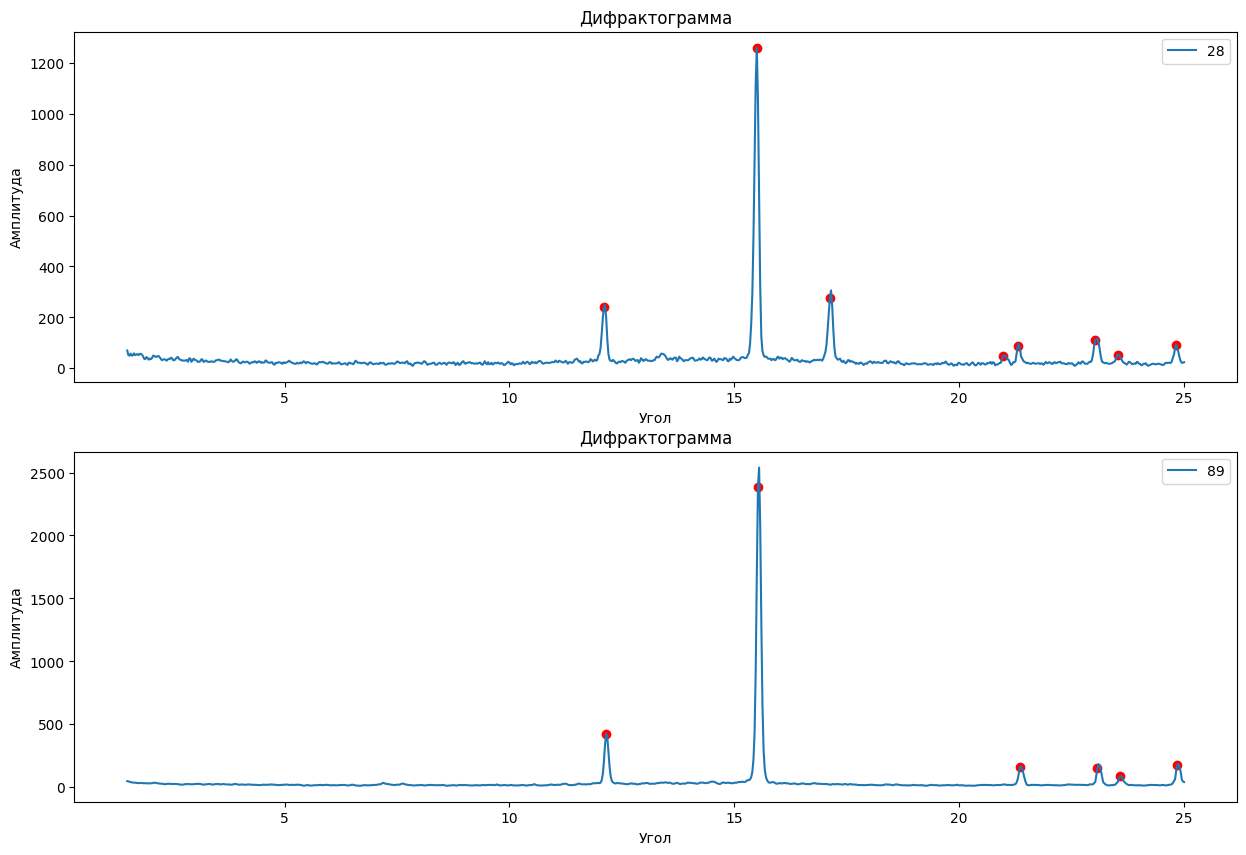

In [5]:
fig, axs = plt.subplots(2,1, figsize = (15,10))
axs[0].plot(angles, xrd_data[28], label="28")
axs[0].scatter(angles[peaks_28], xrd_data[28][peaks_28], c="r")
axs[1].plot(angles, xrd_data[89], label="89")
axs[1].scatter(angles[peaks_89], xrd_data[89][peaks_89], c="r")
for ax in axs:
    ax.set_xlabel("Угол")
    ax.set_ylabel("Амплитуда")
    ax.set_title("Дифрактограмма")
    ax.legend()
fig.tight_layout

# Удаление фона

In [6]:
def sliding_section(data, length=40):
    filt_data = data.copy()
    replaced_section = np.arange(1, length-1, 1)
    for i in range(len(filt_data)):
        if i < length:
            continue
        x = (i-length, i)
        y = (filt_data[i-length], filt_data[i])
        coef = np.polyfit(x, y, 1)
        line = np.array([coef[0]*xr+coef[1] for xr in replaced_section])
        repl_mask = line < filt_data[i-length+1:i-1]
        filt_data[i-length+1:i-1][repl_mask] = line[repl_mask]
        replaced_section+=1
    return filt_data

<bound method Figure.tight_layout of <Figure size 1500x1000 with 2 Axes>>

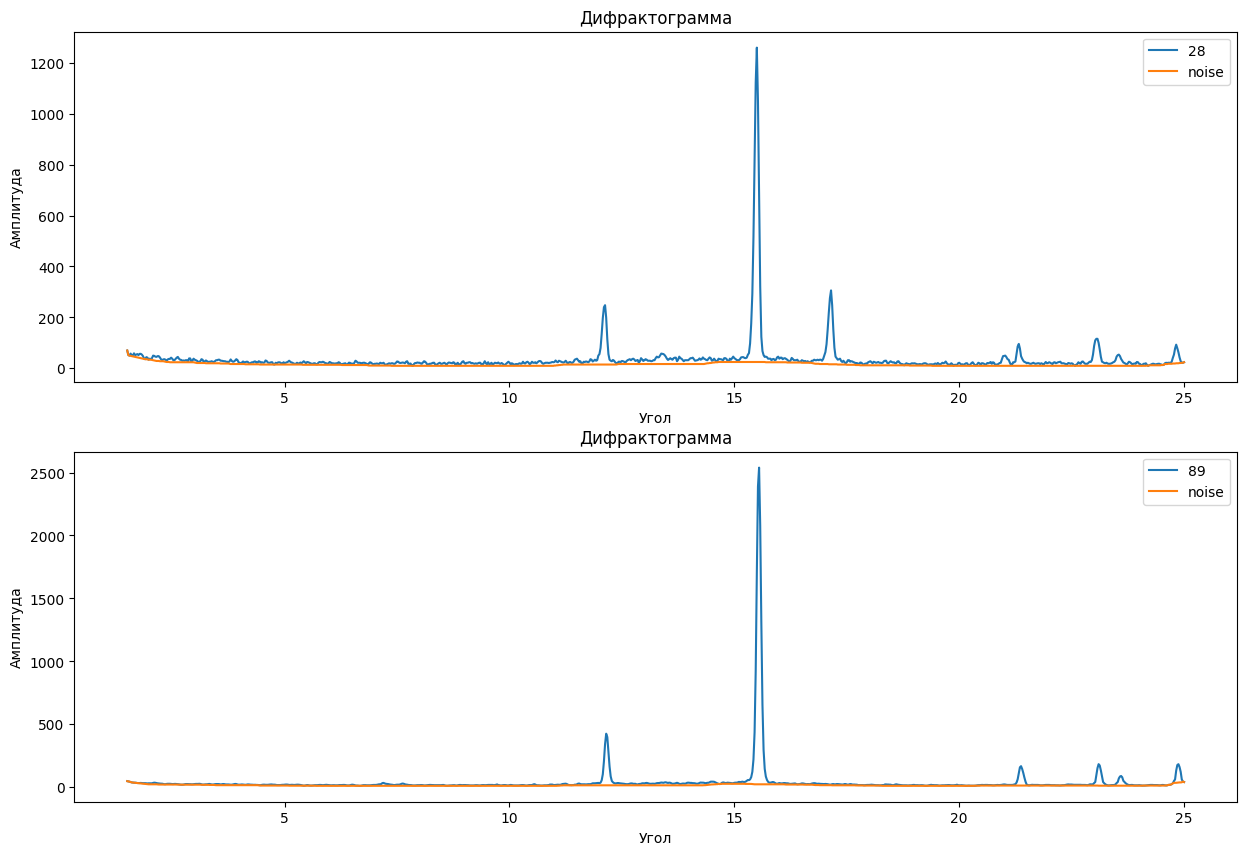

In [7]:
noise_28 = sliding_section(xrd_data[28])
noise_89 = sliding_section(xrd_data[89])

fig, axs = plt.subplots(2,1, figsize = (15,10))
axs[0].plot(angles, xrd_data[28], label="28")
axs[1].plot(angles, xrd_data[89], label="89")
axs[0].plot(angles, noise_28, label="noise")
axs[1].plot(angles, noise_89, label="noise")
for ax in axs:
    ax.set_xlabel("Угол")
    ax.set_ylabel("Амплитуда")
    ax.set_title("Дифрактограмма")
    ax.legend()
fig.tight_layout

# Пикировка Корреляцией

Text(0.5, 1.0, 'Эталонный импульс')

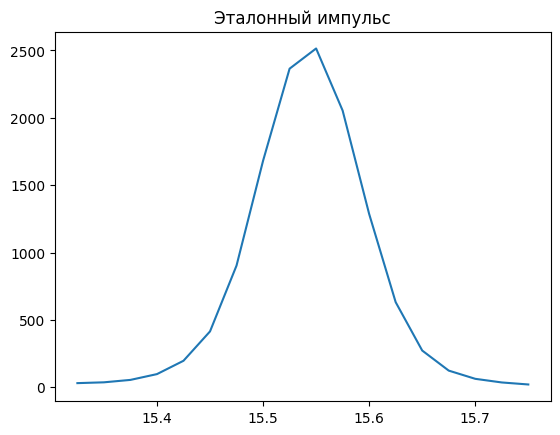

In [8]:
standard_impulse = xrd_data[89][peaks_89[1]-8:peaks_89[1]+10] - noise_89[peaks_89[1]-8:peaks_89[1]+10]
standard_angles = angles[peaks_89[1]-8:peaks_89[1]+10]
plt.plot(standard_angles, standard_impulse)
plt.title("Эталонный импульс")

In [19]:
def find_peaks_custom(signal_init, template, n):
    signal = signal_init.copy()
    peaks = []
    np.correlate(signal, template, mode='full')[:-(template.shape[0]-1)]
    for i in range(n):
        peaks.append(signal.argmax())
        signal[peaks[i]-7: peaks[i]+7] = 0
    return peaks

<bound method Figure.tight_layout of <Figure size 1500x1000 with 2 Axes>>

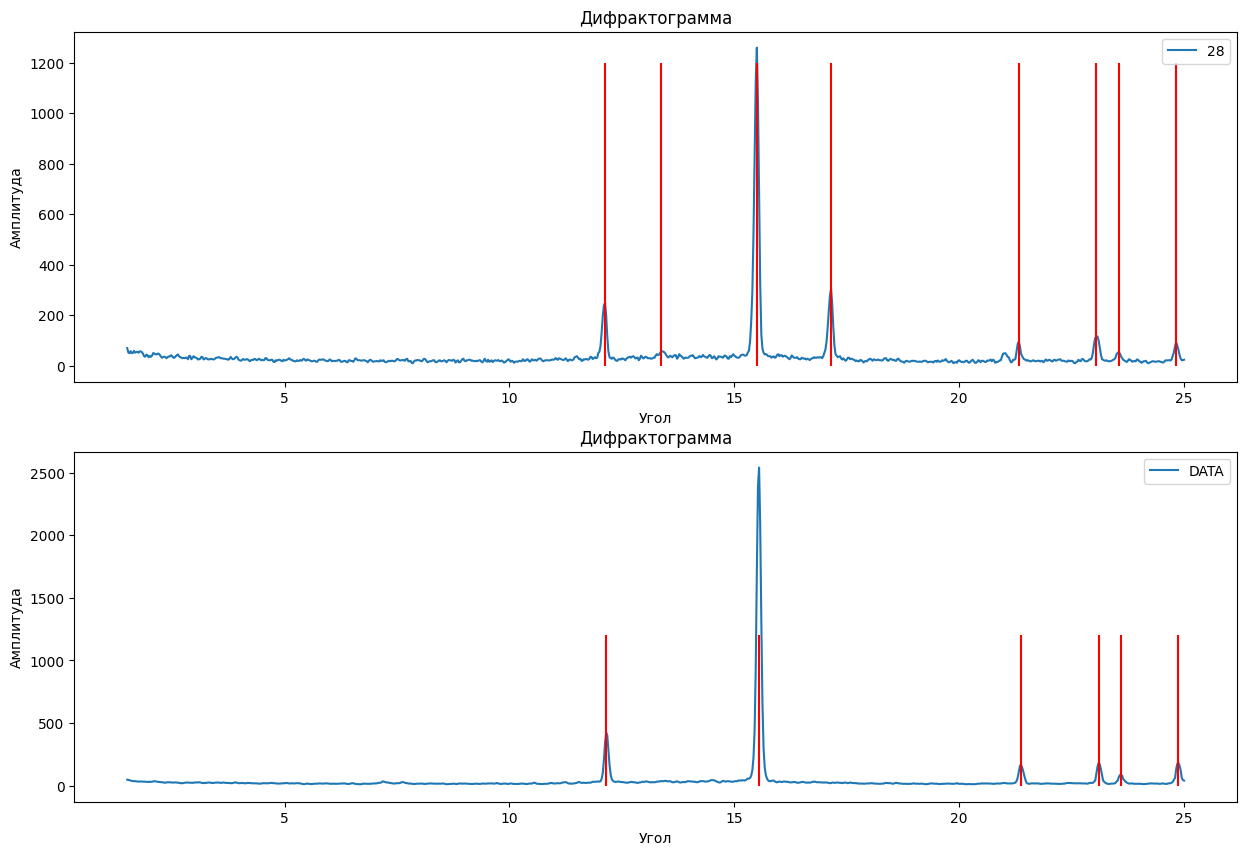

In [29]:
peaks_28 = find_peaks_custom(xrd_data[28]-noise_28, standard_impulse, 8)
peaks_89 = find_peaks_custom(xrd_data[89]-noise_89, standard_impulse, 6)

fig, axs = plt.subplots(2,1, figsize = (15,10))
axs[0].plot(angles, xrd_data[28], label="28")
axs[0].vlines(angles[peaks_28], 0, 1200, colors="r")

axs[1].plot(angles, xrd_data[89], label="DATA")
axs[1].vlines(angles[peaks_89], 0, 1200, colors="r")

for ax in axs:
    ax.set_xlabel("Угол")
    ax.set_ylabel("Амплитуда")
    ax.set_title("Дифрактограмма")
    ax.legend()
fig.tight_layout